In [1]:
from asm import propagate_spatial_asm, propagate_asm_spatiotemporal
import matplotlib.pyplot as plt
import jax.numpy as jnp

In [2]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to mtch 10pt font in document
    "axes.labelsize": 9,
    "font.size": 9,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9
}

plt.style.use('seaborn-v0_8-white')
plt.rcParams.update(tex_fonts)

# Spatial Propagation

In [3]:
N = 2048                # Number of grid points per side
L = 1.0e-3              # Grid side length (2 mm)
wavelength = 800e-9     # Wavelength (800 nm)
w0 = 100e-6             # Initial beam waist (100 um)

z_R = (jnp.pi * w0**2) / wavelength
z_prop = 2.0 * z_R

x = jnp.linspace(-L/2, L/2, N)
y = jnp.linspace(-L/2, L/2, N)
X, Y = jnp.meshgrid(x, y, indexing='ij')

# --- Initial Field (Gaussian Beam at z=0) ---
E_in = jnp.exp(-(X**2 + Y**2) / w0**2)
E_in = E_in.astype(jnp.complex128) # Ensure complex type
I_in = jnp.abs(E_in)**2

E_out = propagate_spatial_asm(E_in, z_prop, L, wavelength)
I_out = jnp.abs(E_out)**2

slice_in = I_in[N//2, :]
slice_out = I_out[N//2, :]
x_mm = x * 1e3 # x-axis in mm

W1204 10:58:48.026407   12076 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1204 10:58:48.028567   12000 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
/home/juardilag/miniconda3/envs/work/lib/python3.14/site-packages/jax/_src/numpy/array_methods.py:125: UserWarning: Explicitly requested dtype complex128 requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


/tmp/ipykernel_12000/2891406077.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


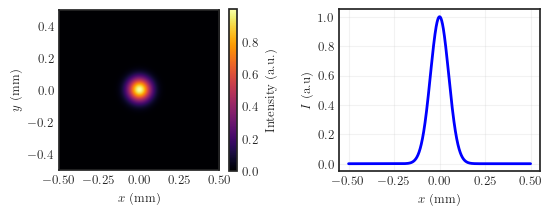

In [4]:
fig, ax = plt.subplots(1,2,figsize=(6.2, 2.1), gridspec_kw={'wspace': 0.4})

im = ax[0].imshow(I_in, extent=[x_mm[0], x_mm[-1], x_mm[0], x_mm[-1]], cmap='inferno', interpolation='bilinear')
ax[0].set_xlabel(r'$x$ (mm)')
ax[0].set_ylabel(r'$y$ (mm)')
plt.colorbar(im, label='Intensity (a.u.)')

ax[1].plot(x_mm, slice_in / jnp.max(slice_in), label='Input', color='blue', linewidth=2)
ax[1].grid(alpha = 0.25)
ax[1].set_xlabel(r'$x$ (mm)')
ax[1].set_ylabel(r'$I$ (a.u)')

plt.tight_layout()
plt.savefig('initial_space_profile.png', dpi = 300, bbox_inches ='tight')
plt.show()

/tmp/ipykernel_12000/2396085306.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


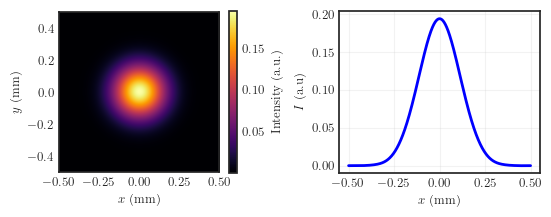

In [5]:
fig, ax = plt.subplots(1,2,figsize=(6.2, 2.1), gridspec_kw={'wspace': 0.4})

im = ax[0].imshow(I_out, extent=[x_mm[0], x_mm[-1], x_mm[0], x_mm[-1]], cmap='inferno', interpolation='bilinear')
ax[0].set_xlabel(r'$x$ (mm)')
ax[0].set_ylabel(r'$y$ (mm)')
plt.colorbar(im, label='Intensity (a.u.)')

ax[1].plot(x_mm, slice_out / jnp.max(slice_in), label='Input', color='blue', linewidth=2)
ax[1].grid(alpha = 0.25)
ax[1].set_xlabel(r'$x$ (mm)')
ax[1].set_ylabel(r'$I$ (a.u)')
    
plt.tight_layout()
plt.savefig('final_space_profile.png', dpi = 300, bbox_inches ='tight')
plt.show()

# Spatio-Temporal Propagation

In [6]:
# --- Simulation Parameters ---

# Spatial
N_x = 256              # Number of spatial grid points
L = 1.0e-3              # Grid side length (2 mm)
w0 = 100e-6             # Initial beam waist (100 um)

# Temporal
N_t = 256               # Number of temporal grid points (can be smaller now)
T = 5.0e-12            # Total time window (10 ps)
tau_0 = 1.0e-12         # Pulse duration (1 ps)

# Wavelength / Frequency
wavelength_0 = 800e-9   # Central wavelength (800 nm)

# Propagation
z_R = (jnp.pi * w0**2) / wavelength_0
z_prop = 2.0 * z_R  # Propagate by 1 Rayleigh range
# --- Grid Setup ---
# Spatial
x = jnp.linspace(-L/2, L/2, N_x)
X, Y = jnp.meshgrid(x, x, indexing='ij') # (N_x, N_x)

# Temporal
dt = T / N_t
t = jnp.linspace(-T/2, T/2, N_t) # (N_t,)

# --- Create 3D (t, x, y) Grids ---
T_grid = t[:, None, None]     # Shape (N_t, 1, 1)
X_grid = X[None, :, :]        # Shape (1, N_x, N_x)
Y_grid = Y[None, :, :]        # Shape (1, N_x, N_x)

# --- Initial Field E(t, x, y) ---
# E = E_spatial * E_temporal_envelope
E_spatial = jnp.exp(-(X_grid**2 + Y_grid**2) / w0**2)

# --- KEY CHANGE ---
# We do *NOT* include the carrier exp(-i*omega_0*t)
E_temporal_env = jnp.exp(-T_grid**2 / (2 * tau_0**2))

E_in_txy = E_spatial * E_temporal_env
E_in_txy = E_in_txy.astype(jnp.complex128) # Ensure complex

t_vec = t

# We pass the central wavelength to the propagator now
E_out_txy = propagate_asm_spatiotemporal(
    E_in_txy, z_prop, L, T, wavelength_0, n_func=None
)

/home/juardilag/miniconda3/envs/work/lib/python3.14/site-packages/jax/_src/numpy/array_methods.py:125: UserWarning: Explicitly requested dtype complex128 requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


In [7]:
# Get intensities
I_in_txy = jnp.abs(E_in_txy)**2
I_out_txy = jnp.abs(E_out_txy)**2

vmax = I_out_txy.max()

x_mm = x * 1e3 # x-axis in mm

/tmp/ipykernel_12000/577074460.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


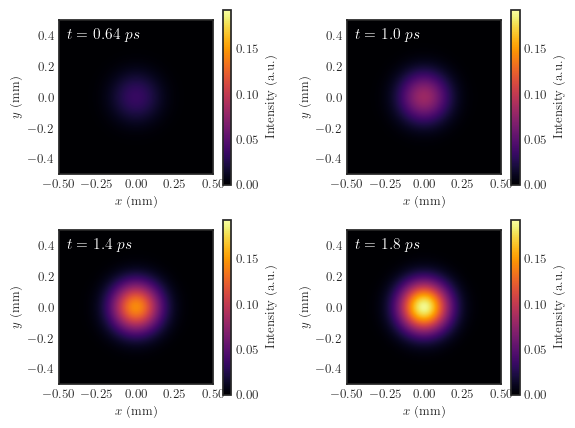

In [8]:
fig, ax = plt.subplots(2,2,figsize=(6.2, 5), gridspec_kw={'hspace': 0.2, 'wspace': 0.5})

im_1 = ax[0,0].imshow(I_out_txy[160,:,:], extent=[x_mm[0], x_mm[-1], x_mm[0], x_mm[-1]], cmap='inferno', interpolation='bilinear',
                    vmin = 0, vmax = vmax)
ax[0,0].set_xlabel(r'$x$ (mm)')
ax[0,0].set_ylabel(r'$y$ (mm)')
ax[0,0].text(0.05, 0.95, r'$t={:.2} \ ps$'.format(t[160]*1e12), transform=ax[0,0].transAxes, 
             fontsize=11, color='white', va='top')
plt.colorbar(im_1, label='Intensity (a.u.)')

im_2 = ax[0,1].imshow(I_out_txy[180,:,:], extent=[x_mm[0], x_mm[-1], x_mm[0], x_mm[-1]], cmap='inferno', interpolation='bilinear',
                    vmin = 0, vmax = vmax)
ax[0,1].set_xlabel(r'$x$ (mm)')
ax[0,1].set_ylabel(r'$y$ (mm)')
ax[0,1].text(0.05, 0.95, r'$t={:.2} \ ps$'.format(t[180]*1e12), transform=ax[0,1].transAxes, 
             fontsize=11, color='white', va='top')
plt.colorbar(im_2, label='Intensity (a.u.)')

im_3 = ax[1,0].imshow(I_out_txy[200,:,:], extent=[x_mm[0], x_mm[-1], x_mm[0], x_mm[-1]], cmap='inferno', interpolation='bilinear',
                    vmin = 0, vmax = vmax)
ax[1,0].set_xlabel(r'$x$ (mm)')
ax[1,0].set_ylabel(r'$y$ (mm)')
ax[1,0].text(0.05, 0.95, r'$t={:.2} \ ps$'.format(t[200]*1e12), transform=ax[1,0].transAxes, 
             fontsize=11, color='white', va='top')
plt.colorbar(im_3, label='Intensity (a.u.)')

im_4 = ax[1,1].imshow(I_out_txy[220,:,:], extent=[x_mm[0], x_mm[-1], x_mm[0], x_mm[-1]], cmap='inferno', interpolation='bilinear',
                    vmin = 0, vmax = vmax)
ax[1,1].set_xlabel(r'$x$ (mm)')
ax[1,1].set_ylabel(r'$y$ (mm)')
ax[1,1].text(0.05, 0.95, r'$t={:.2} \ ps$'.format(t[220]*1e12), transform=ax[1,1].transAxes, 
             fontsize=11, color='white', va='top')
plt.colorbar(im_4, label='Intensity (a.u.)')
    
plt.tight_layout()
plt.savefig('spatio_temporal_propagation.png', dpi = 300, bbox_inches ='tight')
plt.show()

# Second Harmonic Generation

In [9]:
from asm import initialize_gaussian_pulse_3d, run_shg_simulation, normalize_field_to_energy

In [12]:
# --- EXAMPLE CONFIGURATION ---

# 1. Define Sellmeier equations for Ordinary (o) and Extraordinary (e) rays
# (Simplified placeholders for BBO)
def get_n_o(delta_omega): 
    # This should be the Sellmeier for n_o at lambda1
    return 1.66  # Placeholder

def get_n_e(delta_omega):
    # This should be the Sellmeier for n_e(theta) at lambda2
    # If phase matched, n_e(2w) should be close to n_o(w)
    return 1.6601 # Slight mismatch creates fringes (Wait for it!)

# 2. Simulation Params
L = 1e-3 # 1mm grid
T = 1000e-15 # 200 fs
dx = L / N_x
dt = T / N_t
N_x = 256
N_t = 256
w0 = 100e-6 # 100 micron beam
tau = 50e-15 # 50 fs pulse
d_eff = 2.0e-12 # 2 pm/V (Typical BBO value)
z_total = 2e-3 # 2 mm crystal

# 3. Initialize
E1_raw = initialize_gaussian_pulse_3d(N_t, N_x, L, T, w0=100e-6, tau=50e-15)

# 2. Rescale to Physical Units (e.g., 10 nanoJoules)
# This converts the amplitude from "1.0" to roughly "10^8 V/m"
E1_in = normalize_field_to_energy(E1_raw, energy_joules=10e-9, dx=dx, dt=dt, n=1.66)
E2_0 = jnp.zeros_like(E1_in) # Start with no SHG

# 4. Run
E1_final, E2_final = run_shg_simulation(
    E1_in, E2_0, 
    L, T, 
    800e-9, # Fundamental
    get_n_o, # n1 function
    get_n_e, # n2 function
    d_eff, 
    z_total, 
    N_steps=500 # Steps depends on nonlinearity strength. 
                # If d_eff is high, use more steps.
)

Rescaling input field by factor: 5.74e+07


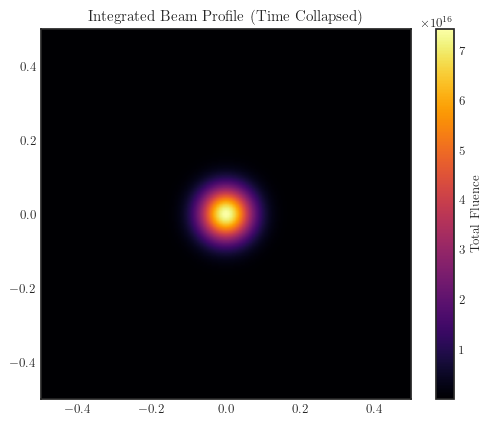

In [13]:
# Collapse the time axis to see the total energy footprint
fluence_map = jnp.sum(jnp.abs(E1_final)**2, axis=0)

plt.figure()
plt.imshow(fluence_map, 
           extent=[x_mm[0], x_mm[-1], x_mm[0], x_mm[-1]], 
           origin='lower',
           cmap='inferno')
plt.colorbar(label="Total Fluence")
plt.title("Integrated Beam Profile (Time Collapsed)")
plt.show()

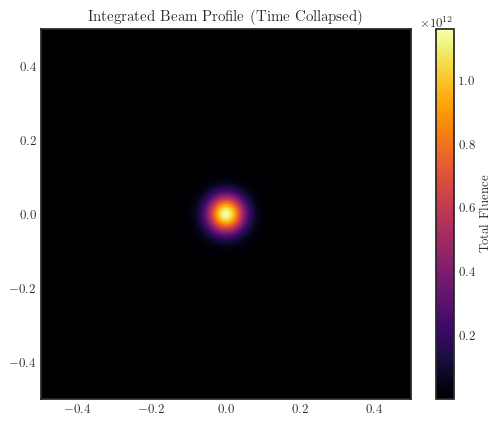

In [14]:
# Collapse the time axis to see the total energy footprint
fluence_map = jnp.sum(jnp.abs(E2_final)**2, axis=0)

plt.figure()
plt.imshow(fluence_map, 
           extent=[x_mm[0], x_mm[-1], x_mm[0], x_mm[-1]], 
           origin='lower',
           cmap='inferno')
plt.colorbar(label="Total Fluence")
plt.title("Integrated Beam Profile (Time Collapsed)")
plt.show()